In [5]:
import pickle
from pathlib import Path
from skimage import io

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# import keras library
import keras
# import Sequential from the keras models module
from keras.models import Sequential
# import Dense, Dropout, Flatten, Conv2D, MaxPooling2D from the keras layers module
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

In [6]:
# load labels.csv from datasets folder using pandas
labels = pd.read_csv('datasets/labels.csv',index_col=0)

# print value counts for genus
print(labels.genus.value_counts())

# assign the genus label values to y
y = labels['genus'].values

0.0    827
1.0    827
Name: genus, dtype: int64


Example image has shape:  (50, 50, 3)
RGB values for the top left pixel are: [127 108  95]


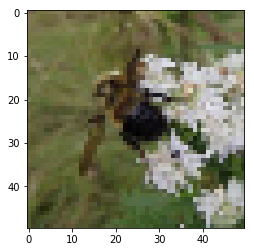

In [16]:
# load an image and explore
example_image = io.imread('datasets/{}.jpg'.format(labels.index[0]))

# show image
plt.imshow(example_image)
# print shape
print('Example image has shape: ', example_image.shape)
                    
# print color channel values for top left pixel
print('RGB values for the top left pixel are:', example_image[0,0])

In [17]:
# initialize standard scaler
ss = StandardScaler()

image_list = []
for i in labels.index:
    # load image
    img = io.imread('datasets/{}.jpg'.format(i)).astype(np.float64)
    
    # for each channel, apply standard scaler's fit_transform method
    for channel in range(img.shape[2]):
        img[:, :, channel] = ss.fit_transform(img[:, :, channel])
        
    # append to list of all images
    image_list.append(img)
    
# convert image list to single array
X = np.array(image_list)

# print shape of X
print(X.shape)

(1654, 50, 50, 3)


In [18]:
# split out evaluation sets (x_eval and y_eval)
x_interim, x_eval, y_interim, y_eval = train_test_split(X,
                                           y,
                                           test_size=0.2,
                                           random_state=52)

# split remaining data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x_interim,
                                           y_interim,
                                           test_size=0.4,
                                           random_state=52)
# examine number of samples in train, test, and validation sets
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print(x_eval.shape[0], 'eval samples')

x_train shape: (793, 50, 50, 3)
793 train samples
530 test samples
331 eval samples


In [19]:
# set model constants
num_classes = 1

# define model as Sequential
model = Sequential()

# first convolutional layer with 32 filters
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(50, 50, 3)))

# add a second 2D convolutional layer with 64 filters
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))

In [20]:
# reduce dimensionality through max pooling
model.add(MaxPooling2D(pool_size=(2,2)))

# third convolutional layer with 64 filters
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
# add dropout to prevent over fitting
model.add(Dropout(0.25))
# necessary flatten step preceeding dense layer
model.add(Flatten())
# fully connected layer
model.add(Dense(128, activation='relu'))

# add additional dropout to prevent overfitting
model.add(Dropout(0.5))
# prediction layers
model.add(Dense(num_classes, activation='sigmoid', name='preds'))

# show model summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 48, 48, 32)        896       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 46, 46, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 21, 21, 64)        36928     
_________________________________________________________________
dropout_3 (Dropout)          (None, 21, 21, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 28224)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               3612800   
__________

In [21]:
model.compile(
    # set the loss as binary_crossentropy
    loss=keras.losses.binary_crossentropy,
    # set the optimizer as stochastic gradient descent
    optimizer=keras.optimizers.SGD(lr=0.001),
    # set the metric as accuracy
    metrics=['accuracy']
)

# mock-train the model using the first ten observations of the train and test sets
model.fit(
    x_train[:10, :, :, :],
    y_train[:10],
    epochs=5,
    verbose=1,
    validation_data=(x_test[:10, :, :, :], y_test[:10])
)

Train on 10 samples, validate on 10 samples
Epoch 1/5
10/10 [==============================] - 3s 347ms/step - loss: 0.7778 - acc: 0.4000 - val_loss: 0.6836 - val_acc: 0.5000
Epoch 2/5
10/10 [==============================] - 0s 15ms/step - loss: 0.7298 - acc: 0.3000 - val_loss: 0.6829 - val_acc: 0.6000
Epoch 3/5
10/10 [==============================] - 0s 17ms/step - loss: 0.7005 - acc: 0.5000 - val_loss: 0.6832 - val_acc: 0.7000
Epoch 4/5
10/10 [==============================] - 0s 15ms/step - loss: 0.6941 - acc: 0.5000 - val_loss: 0.6844 - val_acc: 0.7000
Epoch 5/5
10/10 [==============================] - 0s 14ms/step - loss: 0.6444 - acc: 0.9000 - val_loss: 0.6867 - val_acc: 0.5000


In [24]:
# load pre-trained model
pretrained_cnn = keras.models.load_model('datasets/pretrained_model.h5')

# evaluate model on test set
score = pretrained_cnn.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

print("")

# evaluate model on holdout set
eval_score = pretrained_cnn.evaluate(x_eval, y_eval, verbose=0)
# print loss score
print('Eval loss:', eval_score[0])
# print accuracy score
print('Eval accuracy:', eval_score[1])

Test loss: 0.6423929158246742
Test accuracy: 0.664150944070996

Eval loss: 0.6548949939246624
Eval accuracy: 0.649546827434413


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


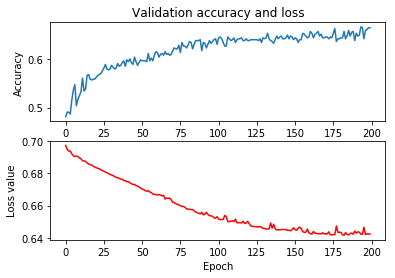

In [28]:
# load history
with open('datasets/model_history.pkl', 'rb') as f:
    pretrained_cnn_history = pickle.load(f)

# print keys for pretrained_cnn_history dict
print(pretrained_cnn_history.keys())

fig = plt.figure(1)
plt.subplot(211)
# plot the validation accuracy
plt.plot(pretrained_cnn_history['val_acc'])
plt.title('Validation accuracy and loss')
plt.ylabel('Accuracy')
plt.subplot(212)
# plot the validation loss
plt.plot(pretrained_cnn_history['val_loss'], 'r')
plt.xlabel('Epoch')
plt.ylabel('Loss value');

In [29]:
# predicted probabilities for x_eval
y_proba = pretrained_cnn.predict(x_eval)
print("First five probabilities:")
print(y_proba[:5])
print("")

# predicted classes for x_eval
y_pred = pretrained_cnn.predict_classes(x_eval)

print("First five class predictions:")
print(y_pred[:5])
print("")

First five probabilities:
[[0.6641951 ]
 [0.60525185]
 [0.75047696]
 [0.32835394]
 [0.88149583]]

First five class predictions:
[[1]
 [1]
 [1]
 [0]
 [1]]

